In [1]:
import boto3 #for AWS
import pandas as pd
import psycopg2 #for SQL
import json 

In [2]:
#reading config file
import configparser
config = configparser.ConfigParser()
config.read_file(open('cluster.config'))

In [3]:
#read the data inside config file
config.get('DWH', 'DWH_IAM_ROLE_NAME')

'redshift-s3-access'

In [ ]:
KEY = config.get('AWS','KEY')
SECRET = config.get('AWS','SECRET')

DWH_CLUSTER_TYPE = config.get('DWH','DWH_CLUSTER_TYPE')
DWH_NUM_NODES = config.get('DWH','DWH_NUM_NODES')
DWH_NODE_TYPE = config.get('DWH','DWH_NODE_TYPE')
DWH_CLUSTER_IDENTIFIER = config.get('DWH','DWH_CLUSTER_IDENTIFIER')

DWH_DB = config.get('DWH','DWH_DB')
DWH_DB_USER = config.get('DWH','DWH_DB_USER')
DWH_DB_PASSWORD = config.get('DWH','DWH_DB_PASSWORD')
DWH_PORT = config.get('DWH','DWH_PORT')
DWH_IAM_ROLE_NAME = config.get('DWH','DWH_IAM_ROLE_NAME')

print((KEY), (SECRET), DWH_IAM_ROLE_NAME)

In [5]:
#converting data into a pandas df just for analysis
pd.DataFrame(
    
{
    "Param": [
"DWH_CLUSTER_TYPE",
"DWH_NUM_NODES", 
"DWH_NODE_TYPE",
"DWH_CLUSTER_IDENTIFIER",
"DWH_DB",
"DWH_DB_USER",
"DWH_DB_PASSWORD",
"DWH_PORT",
"DWH_IAM_ROLE_NAME"],
    
    "Value": [
DWH_CLUSTER_TYPE,
DWH_NUM_NODES, 
DWH_NODE_TYPE,
DWH_CLUSTER_IDENTIFIER,
DWH_DB,
DWH_DB_USER,
DWH_DB_PASSWORD,
DWH_PORT,
DWH_IAM_ROLE_NAME]
    
}

)

,Param,Value
0,DWH_CLUSTER_TYPE,single-node
1,DWH_NUM_NODES,1
2,DWH_NODE_TYPE,dc2.large
3,DWH_CLUSTER_IDENTIFIER,my-first-redshift
4,DWH_DB,flight
5,DWH_DB_USER,awsuser
6,DWH_DB_PASSWORD,Sampath777
7,DWH_PORT,5439
8,DWH_IAM_ROLE_NAME,redshift-s3-access


In [6]:
#creating objects for ec2, iam, redshift, s3

ec2 = boto3.resource('ec2', region_name = "ap-south-1", aws_access_key_id = KEY, aws_secret_access_key = SECRET)

s3= boto3.resource('s3', region_name = "ap-south-1", aws_access_key_id = KEY, aws_secret_access_key = SECRET)

iam = boto3.client('iam', region_name = "ap-south-1",aws_access_key_id = KEY, aws_secret_access_key = SECRET)

redshift = boto3.client('redshift', region_name = "ap-south-1", aws_access_key_id = KEY, aws_secret_access_key = SECRET)

In [7]:
#reading the files inside the bucket

bucket = s3.Bucket("python-datapipeline-project-bucket")
files_inside = [filename.key for filename in bucket.objects.filter(Prefix='')]
files_inside

['allevents_pipe.txt',
 'allusers_pipe.txt',
 'category_pipe.txt',
 'date2008_pipe.txt',
 'listings_pipe.txt',
 'sales_tab.txt',
 'venue_pipe.txt']

In [8]:
#reading the ROLE arn value to give permission to redshift

roleArn = iam.get_role(RoleName = DWH_IAM_ROLE_NAME)['Role']['Arn']
roleArn

'arn:aws:iam::601549810023:role/redshift-s3-access'

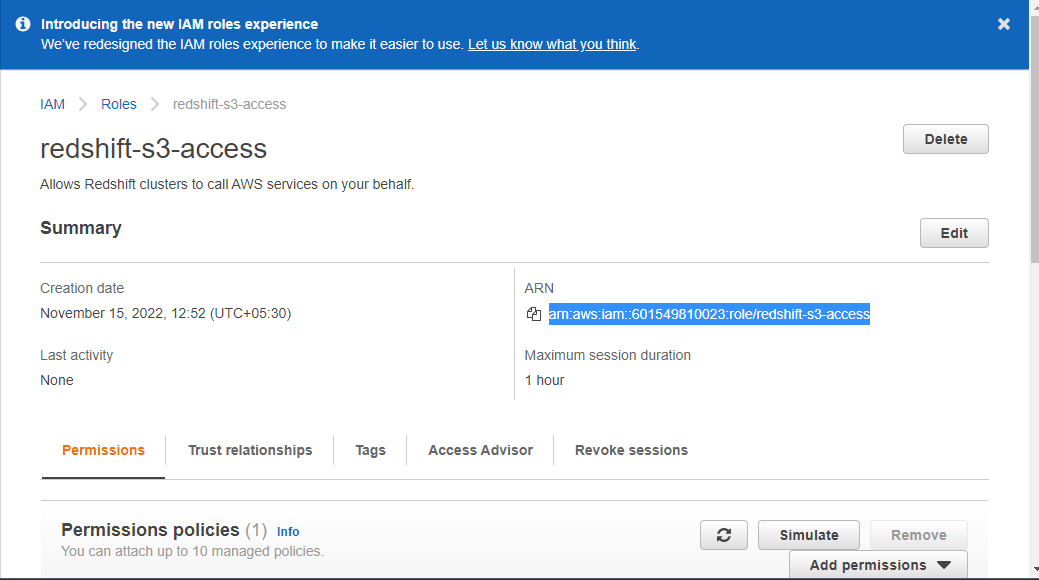


In [9]:
#create cluster in Redshift
try:
    response = redshift.create_cluster(
        
    #cluster related info
    ClusterType = DWH_CLUSTER_TYPE,
    NodeType = DWH_NODE_TYPE,
    
    #db related    
    DBName = DWH_DB,
    ClusterIdentifier = DWH_CLUSTER_IDENTIFIER,
    MasterUsername = DWH_DB_USER,
    MasterUserPassword = DWH_DB_PASSWORD,
    
    #iam credentials
    IamRoles = [roleArn]
    )
    
except Exception as e:
    print(e)

In [10]:
#redshift cluster info using Python

redshift.describe_clusters(ClusterIdentifier = DWH_CLUSTER_IDENTIFIER)['Clusters'][0]

{'ClusterIdentifier': 'my-first-redshift',
 'NodeType': 'dc2.large',
 'ClusterStatus': 'available',
 'ClusterAvailabilityStatus': 'Available',
 'MasterUsername': 'awsuser',
 'DBName': 'flight',
 'Endpoint': {'Address': 'my-first-redshift.cttp7j09jd4m.ap-south-1.redshift.amazonaws.com',
  'Port': 5439},
 'ClusterCreateTime': datetime.datetime(2022, 11, 16, 4, 54, 47, 169000, tzinfo=tzutc()),
 'AutomatedSnapshotRetentionPeriod': 1,
 'ManualSnapshotRetentionPeriod': -1,
 'ClusterSecurityGroups': [],
 'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-0c61e17415b154860',
   'Status': 'active'}],
 'ClusterParameterGroups': [{'ParameterGroupName': 'default.redshift-1.0',
   'ParameterApplyStatus': 'in-sync'}],
 'ClusterSubnetGroupName': 'default',
 'VpcId': 'vpc-0a6259697888f41b0',
 'AvailabilityZone': 'ap-south-1b',
 'PreferredMaintenanceWindow': 'sat:07:00-sat:07:30',
 'PendingModifiedValues': {},
 'ClusterVersion': '1.0',
 'AllowVersionUpgrade': True,
 'NumberOfNodes': 1,
 'PubliclyAccessib

In [11]:
#to get the above information in a proper df, we can write a python function

def redshiftProperties(props):
    keys = ["ClusterIdentifier", "NodeType", "ClusterStatus", "MasterUsername", "DBName", "Endpoint", "VpcId"]
    x = [(k, v) for k, v in props.items() if k in keys]
    return pd.DataFrame(data = x, columns=['Key', 'Value'])

myClusterProps = redshift.describe_clusters(ClusterIdentifier = DWH_CLUSTER_IDENTIFIER)['Clusters'][0]
redshiftProperties(myClusterProps)

,Key,Value
0,ClusterIdentifier,my-first-redshift
1,NodeType,dc2.large
2,ClusterStatus,available
3,MasterUsername,awsuser
4,DBName,flight
5,Endpoint,{'Address': 'my-first-redshift.cttp7j09jd4m.ap...
6,VpcId,vpc-0a6259697888f41b0


In [13]:
#creating variables to store DWH information
DWH_ENDPOINT = myClusterProps['Endpoint']['Address']
DWH_ROLE_ARN = myClusterProps['IamRoles'][0]['IamRoleArn']
DB_NAME = myClusterProps['DBName']
DB_USER = myClusterProps['MasterUsername']

In [17]:
#create security for cluster using VPC through ec2

In [18]:
#Now connecting to Redshift cluster using psycopg2 (SQL api to connect) using python

try:
    conn = psycopg2.connect(host = DWH_ENDPOINT, dbname = DB_NAME, user = DB_USER, password = 'Sampath777', port = 5439)
except Exception as e:
    print("Cannot create connection to database")
    print(e)
    
conn.set_session(autocommit = True)

In [19]:
#creating cursor to execute commands

try:
    cur = conn.cursor()
except Exception as e:
    print("could not get cursor to the db")
    print(e)

In [20]:
#creating table for allusers data

try:
    cur.execute("""
    create table users(
    userid integer not null distkey sortkey,
    username char(8),
    firstname varchar(30),
    lastname varchar(30),
    city varchar(30),
    state char(2),
    email varchar(100),
    phone char(14),
    likesports boolean,
    liketheatre boolean,
    likeconcerts boolean,
    likejazz boolean,
    likeclassical boolean,
    likeopera boolean,
    likerock boolean,
    likevegas boolean,
    likebroadway boolean,
    likemusicals boolean
    );
    """)
except psycopg2.Error as e:
    print('error creating table')
    print(e)

In [22]:
#creating venue table

try:
    cur.execute("""
    create table venue(
    venueid smallint not null distkey sortkey ,
    venuename varchar(100),
    venuecity varchar(30),
    venuestate char(2),
    venueseats integer);
    """)
except psycopg2.Error as e:
    print('error creating table')
    print(e)

In [23]:
#create tables for remaining data

try:
    cur.execute("""
    create table category(
    catid smallint not null distkey sortkey,
    catgroup varchar(10),
    catname varchar(10),
    catdesc varchar(50)
    );
    
    create table date(
    dateid smallint not null distkey sortkey,
    caldate date not null,
    day character(3) not null,
    week smallint not null,
    month character(5) not null,
    qtr character(5) not null,
    year smallint not null,
    holiday boolean default('N')
    );
    
    create table event(
    eventid integer not null distkey,
    venueid smallint not null,
    catid smallint not null,
    dateid smallint not null sortkey, 
    eventname varchar(200),
    starttime timestamp
    );
    
    create table listing(
    listid integer not null distkey, 
    sellerid integer not null,
    eventid integer not null,
    dateid smallint not null sortkey,
    numtickets smallint not null,
    priceperticket decimal(8,2),
    totalprice decimal(8,2),
    listtime timestamp
    );
    
    """)
    
except psycopg2.Error as e:
    print('error creating tables')
    print(e)

In [26]:
#now sending the data from s3 to tables in Redshift using COPY command

try:
    cur.execute("""
    copy users from 's3://python-datapipeline-project-bucket/allusers_pipe.txt'
    credentials 'aws_iam_role=arn:aws:iam::601549810023:role/redshift-s3-access'
    delimiter '|'
    region 'ap-south-1'
    """)
except psycopg2.Error as e:
    print('errooorrrr')
    print(e)

In [27]:
try:
    cur.execute("""
    copy venue from 's3://python-datapipeline-project-bucket/venue_pipe.txt'
    credentials 'aws_iam_role=arn:aws:iam::601549810023:role/redshift-s3-access'
    delimiter '|'
    region 'ap-south-1'
    """)
except psycopg2.Error as e:
    print('errooorrrr')
    print(e)

In [28]:
try:
    cur.execute("""
    copy category from 's3://python-datapipeline-project-bucket/category_pipe.txt'
    credentials 'aws_iam_role=arn:aws:iam::601549810023:role/redshift-s3-access'
    delimiter '|'
    region 'ap-south-1'
    """)
except psycopg2.Error as e:
    print('errooorrrr')
    print(e)

In [29]:
try:
    cur.execute("""
    copy date from 's3://python-datapipeline-project-bucket/date2008_pipe.txt'
    credentials 'aws_iam_role=arn:aws:iam::601549810023:role/redshift-s3-access'
    delimiter '|'
    region 'ap-south-1'
    """)
except psycopg2.Error as e:
    print('errooorrrr')
    print(e)

In [31]:
try:
    cur.execute("""
    copy event from 's3://python-datapipeline-project-bucket/allevents_pipe.txt'
    credentials 'aws_iam_role=arn:aws:iam::601549810023:role/redshift-s3-access'
    delimiter '|'
    region 'ap-south-1'
    """)
except psycopg2.Error as e:
    print('errooorrrr')
    print(e)

In [32]:
try:
    cur.execute("""
    copy listing from 's3://python-datapipeline-project-bucket/listings_pipe.txt'
    credentials 'aws_iam_role=arn:aws:iam::601549810023:role/redshift-s3-access'
    delimiter '|'
    region 'ap-south-1'
    """)
except psycopg2.Error as e:
    print('errooorrrr')
    print(e)

In [33]:
#we should close the connection

try:
    conn.close()
except psycopg2.Error as e:
    print(e)

In [35]:
#deleting the Redshift cluster

redshift.delete_cluster(ClusterIdentifier = DWH_CLUSTER_IDENTIFIER, SkipFinalClusterSnapshot = True)

{'Cluster': {'ClusterIdentifier': 'my-first-redshift',
  'NodeType': 'dc2.large',
  'ClusterStatus': 'deleting',
  'ClusterAvailabilityStatus': 'Modifying',
  'MasterUsername': 'awsuser',
  'DBName': 'flight',
  'Endpoint': {'Address': 'my-first-redshift.cttp7j09jd4m.ap-south-1.redshift.amazonaws.com',
   'Port': 5439},
  'ClusterCreateTime': datetime.datetime(2022, 11, 16, 4, 54, 47, 169000, tzinfo=tzutc()),
  'AutomatedSnapshotRetentionPeriod': 1,
  'ManualSnapshotRetentionPeriod': -1,
  'ClusterSecurityGroups': [],
  'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-0c61e17415b154860',
    'Status': 'active'}],
  'ClusterParameterGroups': [{'ParameterGroupName': 'default.redshift-1.0',
    'ParameterApplyStatus': 'in-sync'}],
  'ClusterSubnetGroupName': 'default',
  'VpcId': 'vpc-0a6259697888f41b0',
  'AvailabilityZone': 'ap-south-1b',
  'PreferredMaintenanceWindow': 'sat:07:00-sat:07:30',
  'PendingModifiedValues': {},
  'ClusterVersion': '1.0',
  'AllowVersionUpgrade': True,
  'Num